In [1]:
import pandas as pd
dataset_names = pd.read_csv("ImageKey.csv")

In [3]:
dataset_names

,Folder1,Folder2,Picture Group,Timestamp,Image,Background Capture,Brand,Brick,Unnamed: 8,Unnamed: 9
0,Cropped Images,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_crop3.jpg,181013_16_45_24_bg3.jpg,Brick,2x2 L,NaN,NaN
1,Cropped Images,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_crop2.jpg,181013_16_45_24_bg2.jpg,Brick,2x2 L,NaN,NaN
2,Cropped Images,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_crop1.jpg,181013_16_45_24_bg1.jpg,Brick,2x2 L,NaN,NaN
3,Cropped Images,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_crop0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
4,Base Images,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_cam3.jpg,181013_16_45_24_bg3.jpg,Brick,2x2 L,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
45666,Base Images,Additional 1x1 Captures,6074,18-10-24 19:34:28,181024_19_34_28_Lego_1x1_cam3.jpg,181024_18_20_09_bg3.jpg,Lego,1x1,NaN,NaN
45667,Base Images,Additional 1x1 Captures,6074,18-10-24 19:34:28,181024_19_34_28_Lego_1x1_cam2.jpg,181024_18_20_09_bg2.jpg,Lego,1x1,NaN,NaN
45668,Base Images,Additional 1x1 Captures,6074,18-10-24 19:34:28,181024_19_34_28_Lego_1x1_cam1.jpg,181024_18_20_09_bg1.jpg,Lego,1x1,NaN,NaN
45669,Base Images,Additional 1x1 Captures,6074,18-10-24 19:34:28,181024_19_34_28_Lego_1x1_cam0.jpg,181024_18_20_09_bg0.jpg,Lego,1x1,NaN,NaN


In [14]:
dataset_reduced = dataset_names[dataset_names.Folder1.isin(['Four Cameras'])].reset_index()

In [15]:
dataset_reduced

,index,Folder1,Folder2,Picture Group,Timestamp,Image,Background Capture,Brand,Brick,Unnamed: 8,Unnamed: 9
0,5,Four Cameras,Bricks,1000,18-10-13 16:45:42,181013_16_45_42_Brick_2x1_L_allcams0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
1,17,Four Cameras,Bricks,1001,18-10-13 16:46:03,181013_16_46_03_Brick_2x1_L_allcams0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
2,22,Four Cameras,Bricks,1002,18-10-13 16:46:22,181013_16_46_22_Brick_2x1_L_allcams0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
3,35,Four Cameras,Bricks,1003,18-10-13 16:46:40,181013_16_46_40_Brick_2x1_L_allcams0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
4,44,Four Cameras,Bricks,1004,18-10-13 16:46:57,181013_16_46_57_Brick_2x1_L_allcams0.jpg,181013_16_45_24_bg0.jpg,Brick,2x2 L,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5070,45634,Four Cameras,Additional 1x1 Captures,6070,18-10-24 19:32:48,181024_19_32_48_Lego_1x1_allcams0.jpg,181024_18_20_09_bg0.jpg,Lego,1x1,NaN,NaN
5071,45643,Four Cameras,Additional 1x1 Captures,6071,18-10-24 19:33:23,181024_19_33_23_Lego_1x1_allcams0.jpg,181024_18_20_09_bg0.jpg,Lego,1x1,NaN,NaN
5072,45652,Four Cameras,Additional 1x1 Captures,6072,18-10-24 19:33:43,181024_19_33_42_Lego_1x1_allcams0.jpg,181024_18_20_09_bg0.jpg,Lego,1x1,NaN,NaN
5073,45661,Four Cameras,Additional 1x1 Captures,6073,18-10-24 19:34:04,181024_19_34_04_Lego_1x1_allcams0.jpg,181024_18_20_09_bg0.jpg,Lego,1x1,NaN,NaN


In [7]:
45671/9

5074.555555555556

In [20]:
print(dataset_reduced.loc[0])

index                                                        5
Folder1                                           Four Cameras
Folder2                                                 Bricks
Picture Group                                             1000
Timestamp                                    18-10-13 16:45:42
Image                 181013_16_45_42_Brick_2x1_L_allcams0.jpg
Background Capture                     181013_16_45_24_bg0.jpg
Brand                                                    Brick
Brick                                                    2x2 L
Unnamed: 8                                                 NaN
Unnamed: 9                                                 NaN
Name: 0, dtype: object


In [37]:
for i in dataset_reduced.index:
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697


4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848


In [40]:
from PIL import Image
from pathlib import Path
import numpy as np
scaled_size = (512,512)
images = []
for i in dataset_reduced.index:
    img = Image.open(Path(dataset_reduced.loc[i].Folder1) / Path(dataset_reduced.loc[i].Folder1) / Path(dataset_reduced.loc[i].Folder2) / Path(dataset_reduced.loc[i].Image))
    img_arr = np.asarray(img.resize(scaled_size))
    images.append(img_arr)
dataset_images = np.stack(images)


<IPython.core.display.Javascript object>


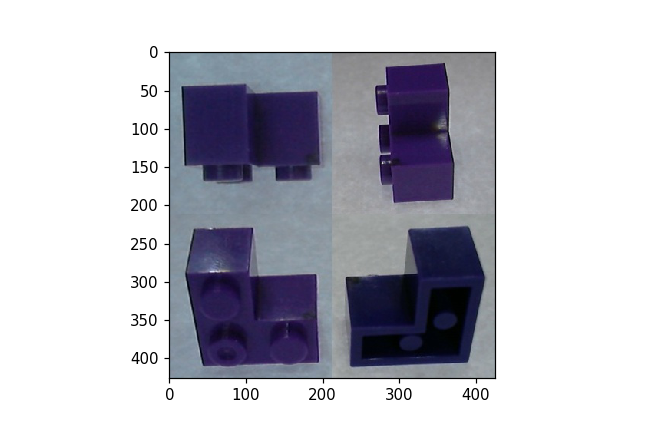

In [30]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.imshow(img)

In [24]:
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [41]:
print(dataset_images.shape)

(5075, 512, 512, 3)


In [45]:
dataset_classes = list(dataset_reduced.Brand)
out = [0 if x == 'Brick' else 1 for x in dataset_classes]
dataset_classes = np.array(out)
print(dataset_classes.shape)

(5075,)
